In [1]:
import pprint
import os
import re
import pandas as pd
import numpy as np
import scipy
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [3]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [4]:
query_dir = 'queries'

In [5]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [6]:
query_client = bigquery.Client()

In [7]:
request = queries['combined_analysis_data.sql']

In [8]:
data = query_client.query(request).to_dataframe()

In [9]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2893 entries, 0 to 3272
Data columns (total 22 columns):
ad_id                 2893 non-null int64
apt_id                1851 non-null object
new_building          2893 non-null bool
num_bedrooms          2847 non-null float64
floor                 2353 non-null float64
primary_size          2893 non-null float64
total_size            2814 non-null float64
price                 2893 non-null float64
property_type         2893 non-null object
ownership_type        2893 non-null object
construction_year     2891 non-null float64
energy_character      1149 non-null object
common_expenses       777 non-null float64
brokerage_expenses    1039 non-null float64
common_wealth         561 non-null float64
common_debt           913 non-null float64
time_s                2774 non-null float64
lat                   2774 non-null float64
lng                   2774 non-null float64
address               2893 non-null object
short_description     2893

In [11]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,brokerage_expenses,common_wealth,common_debt,time_s,lat,lng,address,short_description,full_description
0,78653360,A04-1,True,3.0,4.0,83.0,88.0,5810406.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,2329.0,59.942419,11.058887,"Strandvegen 1, 2...",RÆLINGEN/STRANDV...,Om ProsjektetI S...
1,78653360,A05-1,True,3.0,5.0,83.0,88.0,5910406.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,2329.0,59.942419,11.058887,"Strandvegen 1, 2...",RÆLINGEN/STRANDV...,Om ProsjektetI S...
2,78653360,B05-1,True,3.0,5.0,92.0,96.0,5912150.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,2329.0,59.942419,11.058887,"Strandvegen 1, 2...",RÆLINGEN/STRANDV...,Om ProsjektetI S...
3,78653360,C04-1,True,3.0,4.0,91.0,95.0,5811932.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,2329.0,59.942419,11.058887,"Strandvegen 1, 2...",RÆLINGEN/STRANDV...,Om ProsjektetI S...
4,78653360,C05-1,True,3.0,5.0,91.0,95.0,5911932.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,NaN,2329.0,59.942419,11.058887,"Strandvegen 1, 2...",RÆLINGEN/STRANDV...,Om ProsjektetI S...


In [12]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [13]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [14]:
def assert_address_in_oslo(address):
    return re.match(r'.*oslo.*', address, re.I) is not None

In [15]:
data['post_code'] = data.address.apply(get_postcode_from_address)

In [16]:
data['address_in_oslo'] = data.address.apply(assert_address_in_oslo)

In [17]:
num_cols = ['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year', 'lat', 'lng']
cat_cols = ['new_building', 'energy_letter', 'energy_color', 'property_type', 'ownership_type', 'address_in_oslo']
text_cols = ['short_description', 'full_description']

In [18]:
sample_size = 10

In [19]:
data_random_one_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(sample_size)
                                                                 if len(obj) > sample_size
                                                                 else obj.sample(len(obj)))

In [20]:
num_data = data_random_one_from_new_buildings[num_cols].copy()

In [21]:
cat_data = data_random_one_from_new_buildings[cat_cols].copy()

In [22]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [23]:
text_data = data_random_one_from_new_buildings[text_cols].copy()

In [24]:
num_data['price_per_sq_m'] = num_data.price / num_data.primary_size

In [25]:
num_cat_data_corr = num_data.join(cat_data).corr()

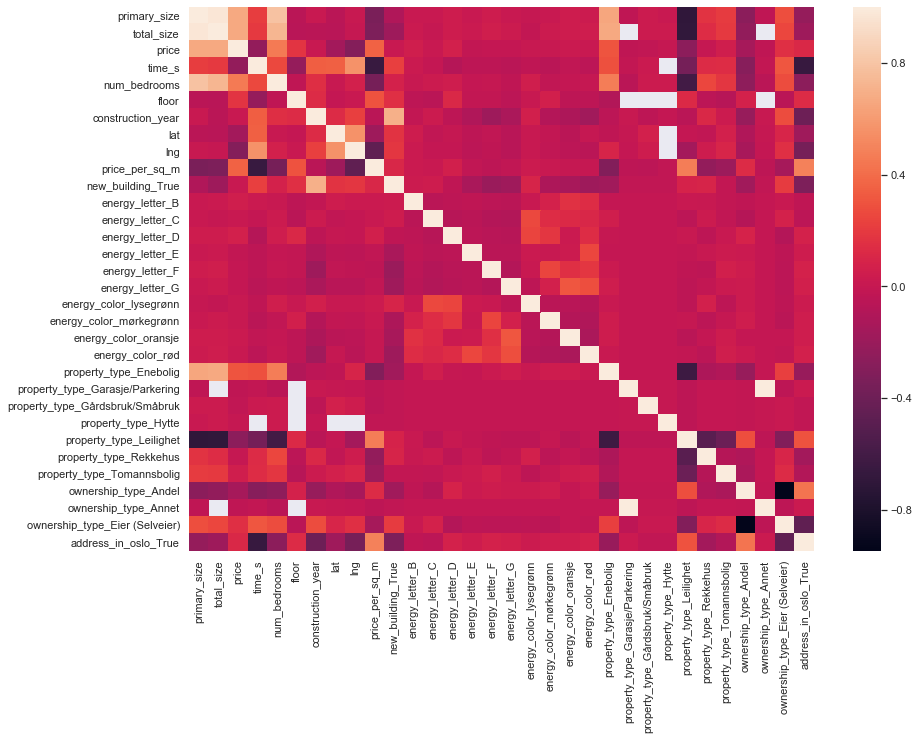

In [26]:
sns.heatmap(num_cat_data_corr)

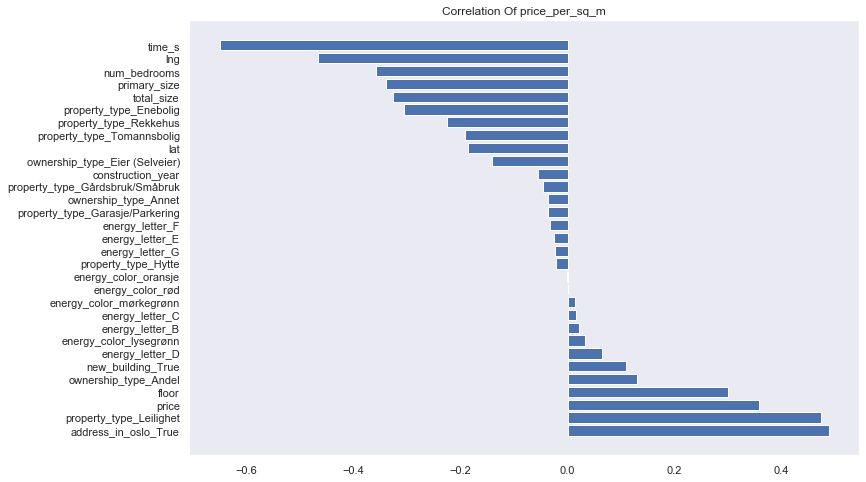

In [27]:
corr_col = 'price_per_sq_m'
to_plot = num_cat_data_corr[corr_col].drop(corr_col).sort_values(ascending=False)
f = plt.figure(figsize=(12, 8))
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title(f'Correlation Of {corr_col}')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With Numeric And Categorical Features

In [100]:
model_data = num_data.join(cat_data)

In [101]:
model_data.dropna(inplace=True)

In [102]:
# model_data = model_data[(model_data.address_in_oslo_True==1) & (model_data.property_type_Leilighet==1)]
# model_data = model_data[model_data.total_size.isin(range(45, 95))]
# model_data = model_data[model_data.price.isin(range(int(3e6), int(8e6)))]

In [103]:
model_data.describe()

,primary_size,total_size,price,time_s,num_bedrooms,floor,construction_year,lat,lng,price_per_sq_m,new_building_True,energy_letter_B,energy_letter_C,energy_letter_D,energy_letter_E,energy_letter_F,energy_letter_G,energy_color_lysegrønn,energy_color_mørkegrønn,energy_color_oransje,energy_color_rød,property_type_Enebolig,property_type_Garasje/Parkering,property_type_Gårdsbruk/Småbruk,property_type_Hytte,property_type_Leilighet,property_type_Rekkehus,property_type_Tomannsbolig,ownership_type_Andel,ownership_type_Annet,ownership_type_Eier (Selveier),address_in_oslo_True
count,1507.000000,1507.000000,1.507000e+03,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.000000,1507.0,1507.0,1507.0,1507.000000,1507.000000,1507.000000,1507.000000,1507.0,1507.000000,1507.000000
mean,80.596549,88.484074,5.507129e+06,2116.573988,2.264101,3.165229,1994.899137,59.943796,10.845825,71274.161196,0.558062,0.028534,0.075647,0.052422,0.027206,0.061712,0.076311,0.031851,0.062376,0.074320,0.125415,0.039151,0.0,0.0,0.0,0.906437,0.028534,0.025216,0.280027,0.0,0.700066,0.522230
std,35.773995,43.110565,2.690862e+06,1260.826932,0.909916,2.027346,37.166120,0.128300,0.218619,22671.097284,0.496782,0.166547,0.264520,0.222951,0.162738,0.240712,0.265582,0.175663,0.241917,0.262378,0.331299,0.194018,0.0,0.0,0.0,0.291317,0.166547,0.156832,0.449161,0.0,0.458381,0.499671
min,14.000000,16.000000,1.514691e+06,326.000000,0.000000,1.000000,1850.000000,59.502466,10.376291,15332.813084,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,59.000000,64.000000,3.669645e+06,1207.000000,2.000000,2.000000,1974.000000,59.911473,10.733915,53717.412935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,75.000000,80.000000,4.800000e+06,1739.000000,2.000000,3.000000,2019.000000,59.928024,10.788570,70334.225000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
75%,90.000000,98.000000,6.663737e+06,2767.000000,3.000000,4.000000,2019.000000,59.954253,10.951467,85652.123311,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.0,1.000000,1.000000
max,368.000000,479.000000,2.460000e+07,8107.000000,8.000000,17.000000,2019.000000,60.428418,11.631935,154875.938462,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [104]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1507 entries, (78653360, 4) to (151052159, 3271)
Data columns (total 32 columns):
primary_size                       1507 non-null float64
total_size                         1507 non-null float64
price                              1507 non-null float64
time_s                             1507 non-null float64
num_bedrooms                       1507 non-null float64
floor                              1507 non-null float64
construction_year                  1507 non-null float64
lat                                1507 non-null float64
lng                                1507 non-null float64
price_per_sq_m                     1507 non-null float64
new_building_True                  1507 non-null uint8
energy_letter_B                    1507 non-null uint8
energy_letter_C                    1507 non-null uint8
energy_letter_D                    1507 non-null uint8
energy_letter_E                    1507 non-null uint8
energy_letter_F        

In [105]:
model_data.columns

Index(['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms',
       'floor', 'construction_year', 'lat', 'lng', 'price_per_sq_m',
       'new_building_True', 'energy_letter_B', 'energy_letter_C',
       'energy_letter_D', 'energy_letter_E', 'energy_letter_F',
       'energy_letter_G', 'energy_color_lysegrønn', 'energy_color_mørkegrønn',
       'energy_color_oransje', 'energy_color_rød', 'property_type_Enebolig',
       'property_type_Garasje/Parkering', 'property_type_Gårdsbruk/Småbruk',
       'property_type_Hytte', 'property_type_Leilighet',
       'property_type_Rekkehus', 'property_type_Tomannsbolig',
       'ownership_type_Andel', 'ownership_type_Annet',
       'ownership_type_Eier (Selveier)', 'address_in_oslo_True'],
      dtype='object')

In [106]:
target = 'price'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [107]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [108]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

In [109]:
selected_cols = ['primary_size', 'price', 'time_s', 'num_bedrooms',
                 'floor', 'construction_year', 'lat', 'lng',
                 'property_type_Enebolig', 'property_type_Leilighet',
                 'property_type_Rekkehus', 'ownership_type_Andel',
                 'ownership_type_Eier (Selveier)', 'address_in_oslo_True']

In [110]:
model_data = model_data[selected_cols]

In [111]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [112]:
x_cols = X.columns

In [113]:
X = scipy.sparse.csr_matrix(X.values)

In [114]:
random_seed = 42
test_size = 0.25

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [116]:
X_train.shape

(1130, 13)

In [117]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [118]:
steps = []

steps.append(('scale', MaxAbsScaler()))
# steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('standardize', StandardScaler()))
# steps.append(('dl', KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False)))
steps.append(('ada', AdaBoostRegressor(n_estimators=100, learning_rate=0.1, loss='square', random_state=random_seed)))
# steps.append(('linear', LinearRegression()))
# steps.append(('kneighbors', KNeighborsRegressor()))
# steps.append(('bayes', ComplementNB()))
# steps.append(('mlp', MLPRegressor()))

In [119]:
pipeline = Pipeline(steps)

In [120]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MaxAbsScaler(copy=True)),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('ada',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.1,
                                   loss='square', n_estimators=100,
                                   random_state=42))],
         verbose=False)

In [121]:
pred = pipeline.predict(X_test)

In [122]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

In [123]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [124]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

Mean mean_abs_err, 1106472.65
Mean med_abs_err, 831238.53
Mean r2_score, 0.59
Mean explained_var, 0.59


In [125]:
cross_val = cross_validate(pipeline, X, y, scoring=['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance'], cv=3)
for key, val in cross_val.items():
    print('Mean {}, {:.2f}'.format(key, val.mean()))

Mean fit_time, 0.31
Mean score_time, 0.06
Mean test_neg_mean_absolute_error, -1240256.08
Mean test_neg_median_absolute_error, -984408.54
Mean test_r2, 0.60
Mean test_explained_variance, 0.65


In [126]:
train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [127]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [128]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

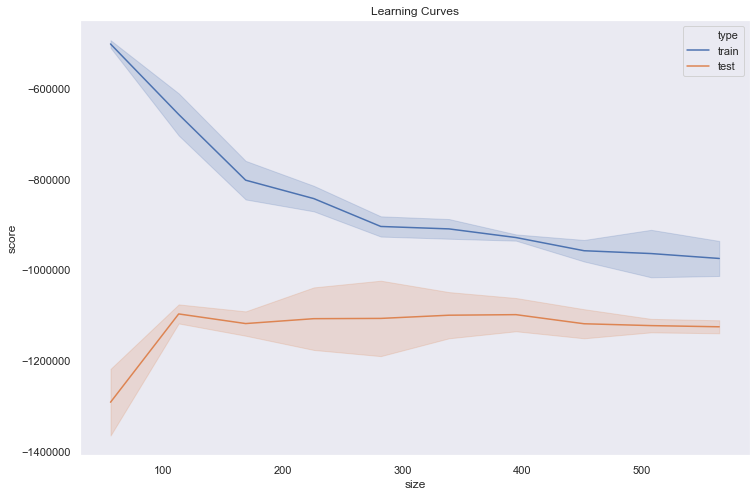

In [129]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)

In [130]:
feature_importances = pd.Series(pipeline.named_steps['ada'].feature_importances_, index=x_cols).sort_values(ascending=True)

In [131]:
feature_importances

property_type_Rekkehus            0.000000
property_type_Enebolig            0.000172
address_in_oslo_True              0.001348
ownership_type_Andel              0.001368
ownership_type_Eier (Selveier)    0.003646
lat                               0.005109
construction_year                 0.010466
floor                             0.014755
num_bedrooms                      0.059208
lng                               0.079833
property_type_Leilighet           0.097922
time_s                            0.171193
primary_size                      0.554981
dtype: float64

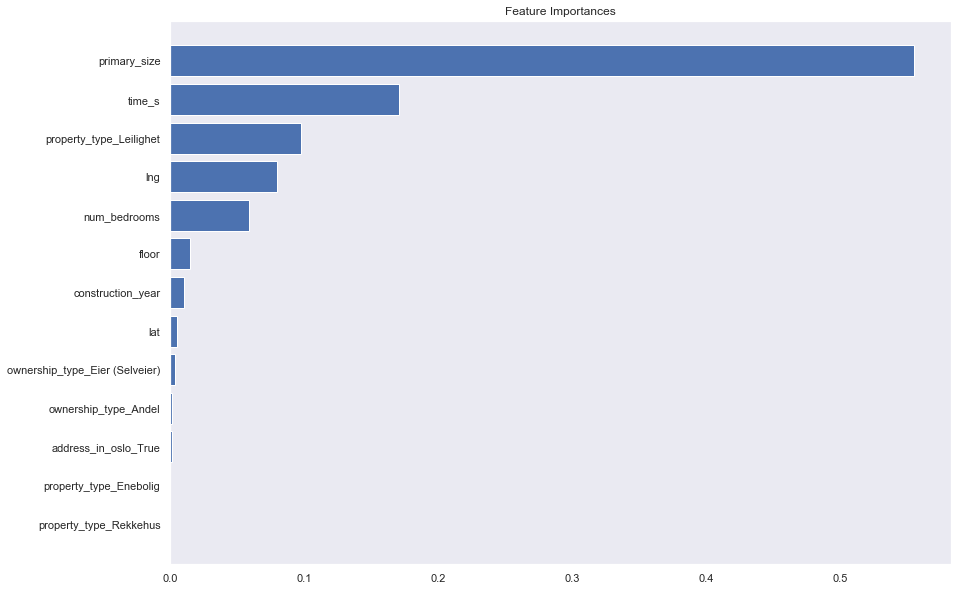

In [132]:
plt.yticks(range(len(feature_importances)), feature_importances.index)
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances)
plt.show()

In [133]:
prop1 = [[225, 1860, 5, 3, 1921, 59.938175, 10.967029, 1, 0, 0, 0, 1, 0]]
prop2 = [[103, 1920, 3, 3, 1978, 59.946532, 10.895096, 0, 1, 0, 1, 0, 1]]
print(int(pipeline.predict(prop1)))
print(int(pipeline.predict(prop2)))

10395127
6757765


In [134]:
# scipy.sparse.hstack

# Predict Price With NLP

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [136]:
stop_words = ['av', 'og', 'til', 'over', 'fra', 'om',
              'den', 'det', 'denne', 'dette', 'ved',
              'in', 'inn', 'en', 'opp', 'ikke', 'oss',
              'for', 'du', 'fortsatt', 'flere', 'eller',
              'hele', 'her', 'men', 'kan', 'meget']

real_estate_terms = ['solgt', 'informasjon', 'bygget',
                     'leiligheter', 'salg', 'solgte', 'bell']

other_terms = ['inkl', 'nn', 'dok', 'str', 'avg', 'yt',
               'kl', 'kj', 'hj', 'schl', 'nyg']

stop_words = stop_words + real_estate_terms + other_terms

In [137]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                   token_pattern = r'[A-z\-]{3,}',
                                   strip_accents=None,
                                   lowercase=True,
                                   stop_words=stop_words,
                                   #vocabulary=
                                   min_df=2,
                                   max_features = 5000)

In [138]:
y = data_random_one_from_new_buildings[data_random_one_from_new_buildings.index.isin(model_data.index)][target]

In [139]:
y.shape

(1507,)

In [140]:
vectorized_full_desc = count_vectorizer.fit_transform(data_random_one_from_new_buildings[data_random_one_from_new_buildings.index.isin(model_data.index)].short_description)

In [141]:
tfidf_transformer = TfidfTransformer()

In [142]:
tfidf_full_desc = tfidf_transformer.fit_transform(vectorized_full_desc)

In [143]:
tfidf_full_desc

<1507x804 sparse matrix of type '<class 'numpy.float64'>'
	with 14497 stored elements in Compressed Sparse Row format>

In [144]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_full_desc, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [145]:
estimator = AdaBoostRegressor(random_state=random_seed)

In [146]:
estimator.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [147]:
y_pred = estimator.predict(X_test)

In [148]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [149]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

Mean mean_abs_err, 2260261.91
Mean med_abs_err, 2178569.28
Mean r2_score, -0.19
Mean explained_var, 0.23


In [150]:
train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [151]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [152]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

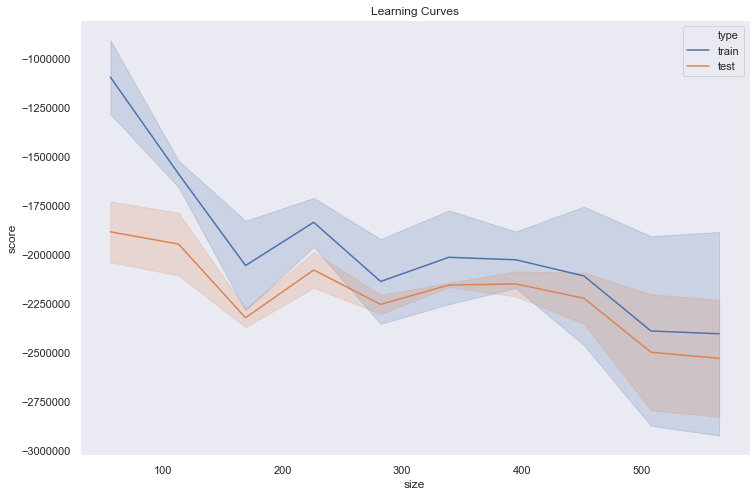

In [153]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)

In [154]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()))

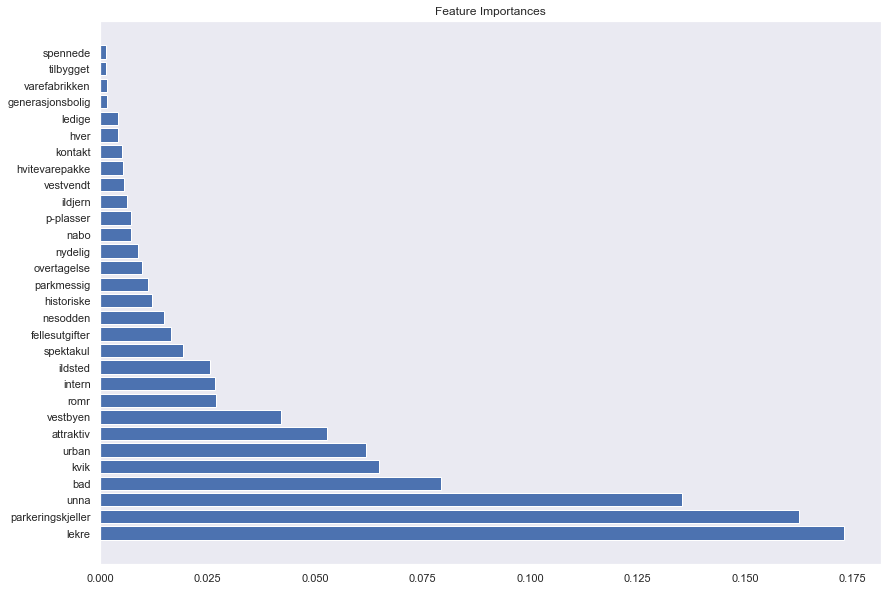

In [155]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With All Features

In [156]:
# all_features = scipy.sparse.hstack([vectorized_full_desc, X])
all_features = scipy.sparse.hstack([tfidf_full_desc, X])

In [157]:
all_features

<1507x817 sparse matrix of type '<class 'numpy.float64'>'
	with 28759 stored elements in COOrdinate format>

In [158]:
X_train, X_test, y_train, y_test = train_test_split(all_features, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [159]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MaxAbsScaler(copy=True)),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('ada',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.1,
                                   loss='square', n_estimators=100,
                                   random_state=42))],
         verbose=False)

In [160]:
y_pred = pipeline.predict(X_test)

In [161]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [162]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

Mean mean_abs_err, 1179955.80
Mean med_abs_err, 955552.56
Mean r2_score, 0.58
Mean explained_var, 0.59


In [163]:
feature_importances = pd.Series(pipeline.named_steps['ada'].feature_importances_, index=list(count_vectorizer.vocabulary_.keys()) + list(x_cols)).sort_values(ascending=True)

In [164]:
feature_importances.sort_values(ascending=False)[:30]

primary_size                      0.573544
time_s                            0.161155
property_type_Leilighet           0.081744
floor                             0.032717
lekre                             0.031180
lng                               0.022655
velstelt                          0.020628
construction_year                 0.010650
parkeringskjeller                 0.007456
togstasjonen                      0.006895
address_in_oslo_True              0.006771
yden                              0.006298
tidsriktig                        0.004451
grefsen                           0.004073
lat                               0.003691
byggearbeid                       0.002703
intern                            0.002682
vestbyen                          0.002325
in-ordning                        0.002264
ownership_type_Eier (Selveier)    0.002189
skjermet                          0.002083
unna                              0.001534
num_bedrooms                      0.001204
nymalt     

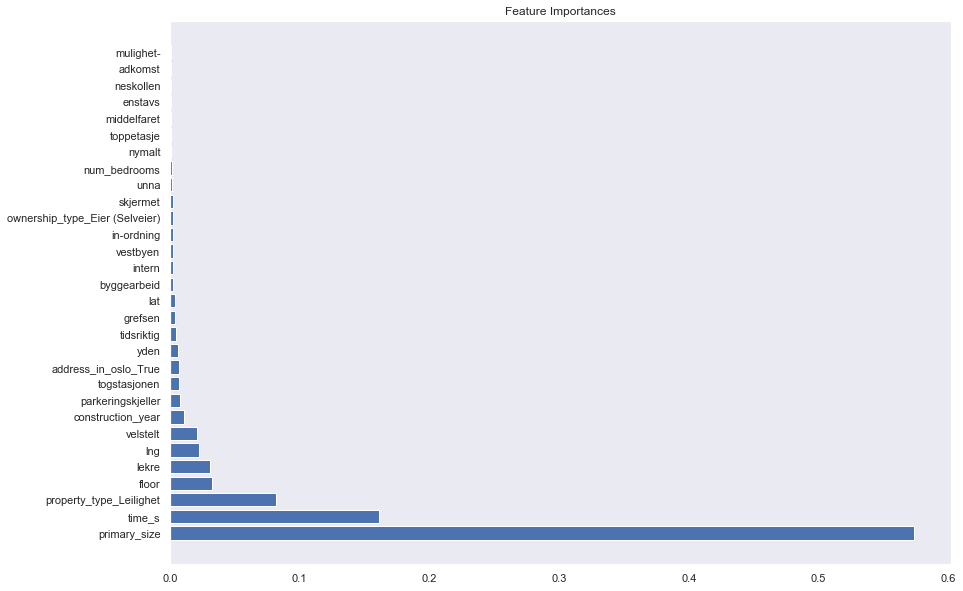

In [165]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [166]:
vocab = pd.Series(list(count_vectorizer.vocabulary_.values()), index=count_vectorizer.vocabulary_.keys())

In [167]:
train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [168]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [169]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

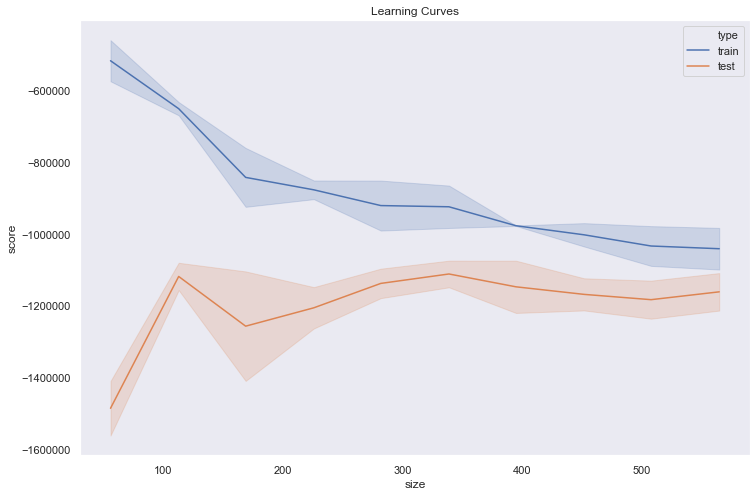

In [170]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)